In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [2]:
data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

print("Dataset importato con successo")

Dataset importato con successo


Total :  13451
Normal :  7500
Malicious :  5951


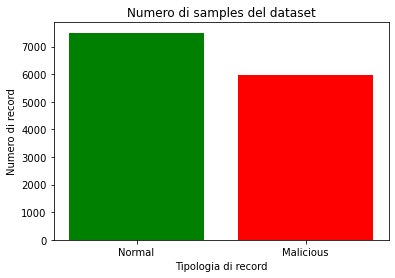

In [3]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [4]:
#Converto tutti gli altri tipi di attacco in anomaly in modo da avere solo o normal o anomaly
def conversione(df):
    datacpy = df.copy()
    for i in range(len(datacpy.result)):
        if(datacpy.result.loc[i] != 'normal'):
            datacpy.result.loc[i] = 'anomaly'
    return datacpy

df_data_confronti = data.copy()
df_data = conversione(data)

C:\Users\39331\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
#Funzioni utili preprocessing

#ottiene una service_list dal file service.txt prelevando ogni riga e inserendola in una lista
def get_service_list(dirname='list', filename='service_mio.txt'):
    print('Getting service list...')
    with open(os.path.join(dirname, filename), 'r') as service:
        service_list = service.read().split('\n')
    return service_list

#ottiene una flag_list dal file flag.txt prelevando ogni riga e inserendola in una lista
def get_flag_list(dirname='list', filename='flag_mio.txt'):
    print('Getting flag list...')
    with open(os.path.join(dirname, filename), 'r') as flag:
        flag_list = flag.read().split('\n')
    return flag_list

In [6]:
service_list = get_service_list(dirname='list', filename='service_mio.txt')
flag_list = get_flag_list(dirname='list', filename='flag_mio.txt')

print('Replacing protocol_type values to numeric...')
df_data.protocol_type.replace(['tcp', 'udp', 'icmp'], range(3), inplace=True)

print('Replacing service values to numeric...')
df_data.service.replace(service_list, range(len(service_list)), inplace=True)

print('Replacing flag values to numeric...')
df_data.flag.replace(flag_list, range(len(flag_list)), inplace=True)

df_data.result.replace(['anomaly','normal'], range(2), inplace=True)

Getting service list...
Getting flag list...
Replacing protocol_type values to numeric...
Replacing service values to numeric...
Replacing flag values to numeric...


In [7]:
sc = MinMaxScaler()
enc = OneHotEncoder(categories=[range(3), range(len(service_list)), range(len(flag_list))])
num_desc = df_data.loc[:, ['duration', 'src_bytes', 'dst_bytes']].describe()

label, df_label = [], []
    
label = df_data['result'].copy().values.reshape((df_data.shape[0], 1))
df_label = pd.DataFrame(label)
df_data.drop(['result'], axis=1, inplace=True)   

attr_name = ['duration', '', '', '', 'src_bytes', 'dst_bytes']

for i in ['duration', 'src_bytes', 'dst_bytes']:
    iqr = (num_desc[i].values[6] - num_desc[i].values[4])
    std = num_desc[i].values[6] + iqr * 1.5  # IQR upper fence = Q3 + 1.5 * IQR
    if std == 0:
        df_data[i] = df_data[i].map(lambda x: 1 if x > 0 else 0)
    else:
        df_data[i] = df_data[i].map(lambda x: std if x > std else x)
sc.fit(df_data[['duration', 'src_bytes', 'dst_bytes']].values)
df_data[['duration', 'src_bytes', 'dst_bytes']] = sc.transform(df_data[['duration', 'src_bytes', 'dst_bytes']].values)

print('Conversione feature "count" in linguaggio macchina . . .')
sc.fit(df_data[['count']].values.astype(np.float32))
df_data[['count']] = sc.transform(data[['count']].values.astype(np.float32))

print('Conversione indici 1,2,3 in linguaggio macchina . . .')
enc.fit(df_data[['protocol_type','service','flag']].values)
one_hot_arr = enc.transform(df_data[['protocol_type','service','flag']].values).toarray()

print('Rimuovo le features di indici 1,2,3 e concateno un hot encoder array')
df_data.drop(['protocol_type','service','flag'], axis=1, inplace=True)
data_final = np.concatenate((df_data.values, one_hot_arr, df_label), axis=1)
data_final = pd.DataFrame(data_final)

print("")
print("")
print('Final shape of data:', data_final.shape)
print("")
print("")


Conversione feature "count" in linguaggio macchina . . .
Conversione indici 1,2,3 in linguaggio macchina . . .
Rimuovo le features di indici 1,2,3 e concateno un hot encoder array


Final shape of data: (13451, 95)




Epoch 1/30
48/48 [==============================] - 7s 140ms/step - loss: 3.2944 - accuracy: 0.8944 - val_loss: 1.4122 - val_accuracy: 0.9950
Epoch 2/30
48/48 [==============================] - 6s 126ms/step - loss: 0.8390 - accuracy: 0.9857 - val_loss: 0.3636 - val_accuracy: 0.9950
Epoch 3/30
48/48 [==============================] - 6s 124ms/step - loss: 0.2688 - accuracy: 0.9865 - val_loss: 0.1325 - val_accuracy: 1.0000
Epoch 4/30
48/48 [==============================] - 6s 126ms/step - loss: 0.1590 - accuracy: 0.9865 - val_loss: 0.0880 - val_accuracy: 0.9950
Epoch 5/30
48/48 [==============================] - 6s 134ms/step - loss: 0.1139 - accuracy: 0.9865 - val_loss: 0.0681 - val_accuracy: 1.0000
Epoch 6/30
48/48 [==============================] - 6s 131ms/step - loss: 0.1026 - accuracy: 0.9874 - val_loss: 0.0690 - val_accuracy: 0.9950
Epoch 7/30
48/48 [==============================] - 7s 136ms/step - loss: 0.0875 - accuracy: 0.9880 - val_loss: 0.2075 - val_accuracy: 0.9500
Epoch 

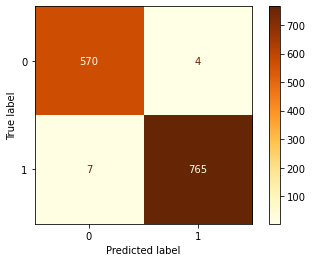

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       574
           1       0.99      0.99      0.99       772

    accuracy                           0.99      1346
   macro avg       0.99      0.99      0.99      1346
weighted avg       0.99      0.99      0.99      1346

Epoch 1/30
48/48 [==============================] - 7s 138ms/step - loss: 3.0004 - accuracy: 0.9090 - val_loss: 1.0533 - val_accuracy: 0.9950
Epoch 2/30
48/48 [==============================] - 6s 131ms/step - loss: 0.5660 - accuracy: 0.9833 - val_loss: 0.2263 - val_accuracy: 0.9950
Epoch 3/30
48/48 [==============================] - 6s 132ms/step - loss: 0.1908 - accuracy: 0.9855 - val_loss: 0.1182 - val_accuracy: 0.9900
Epoch 4/30
48/48 [==============================] - 6s 133ms/step - loss: 0.1433 - accuracy: 0.9795 - val_loss: 0.0856 - val_accuracy: 0.9950
Epoch 5/30
48/48 [==============================] - 6s 130ms/step - loss: 0.1042 - accuracy: 0.9881 - val

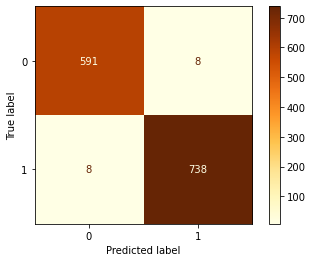

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       599
           1       0.99      0.99      0.99       746

    accuracy                           0.99      1345
   macro avg       0.99      0.99      0.99      1345
weighted avg       0.99      0.99      0.99      1345

Epoch 1/30
48/48 [==============================] - 7s 153ms/step - loss: 3.0538 - accuracy: 0.9180 - val_loss: 1.2660 - val_accuracy: 0.9700
Epoch 2/30
48/48 [==============================] - 7s 142ms/step - loss: 0.6604 - accuracy: 0.9841 - val_loss: 0.2557 - val_accuracy: 1.0000
Epoch 3/30
48/48 [==============================] - 7s 145ms/step - loss: 0.2238 - accuracy: 0.9784 - val_loss: 0.1498 - val_accuracy: 0.9950
Epoch 4/30
48/48 [==============================] - 7s 138ms/step - loss: 0.1481 - accuracy: 0.9864 - val_loss: 0.2054 - val_accuracy: 0.9650
Epoch 5/30
48/48 [==============================] - 6s 135ms/step - loss: 0.1160 - accuracy: 0.9872 - val

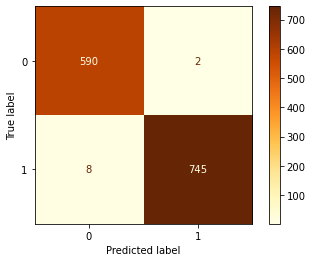

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       592
           1       1.00      0.99      0.99       753

    accuracy                           0.99      1345
   macro avg       0.99      0.99      0.99      1345
weighted avg       0.99      0.99      0.99      1345

Epoch 1/30
48/48 [==============================] - 6s 132ms/step - loss: 2.8288 - accuracy: 0.9028 - val_loss: 0.8949 - val_accuracy: 0.9900
Epoch 2/30
48/48 [==============================] - 6s 133ms/step - loss: 0.5090 - accuracy: 0.9846 - val_loss: 0.2448 - val_accuracy: 0.9800
Epoch 3/30
48/48 [==============================] - 6s 132ms/step - loss: 0.1902 - accuracy: 0.9865 - val_loss: 0.1220 - val_accuracy: 0.9900
Epoch 4/30
48/48 [==============================] - 6s 132ms/step - loss: 0.1361 - accuracy: 0.9822 - val_loss: 0.0861 - val_accuracy: 0.9950
Epoch 5/30
48/48 [==============================] - 6s 130ms/step - loss: 0.1086 - accuracy: 0.9877 - val

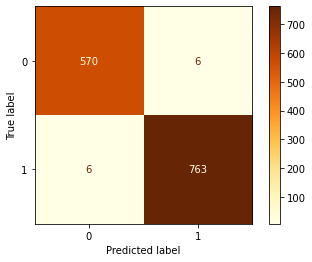

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       576
           1       0.99      0.99      0.99       769

    accuracy                           0.99      1345
   macro avg       0.99      0.99      0.99      1345
weighted avg       0.99      0.99      0.99      1345

Epoch 1/30
48/48 [==============================] - 7s 138ms/step - loss: 3.2887 - accuracy: 0.8997 - val_loss: 1.3647 - val_accuracy: 1.0000
Epoch 2/30
48/48 [==============================] - 6s 131ms/step - loss: 0.7495 - accuracy: 0.9855 - val_loss: 0.2812 - val_accuracy: 1.0000
Epoch 3/30
48/48 [==============================] - 6s 131ms/step - loss: 0.2210 - accuracy: 0.9851 - val_loss: 0.1247 - val_accuracy: 1.0000
Epoch 4/30
48/48 [==============================] - 6s 135ms/step - loss: 0.1344 - accuracy: 0.9869 - val_loss: 0.0782 - val_accuracy: 1.0000
Epoch 5/30
48/48 [==============================] - 6s 134ms/step - loss: 0.1181 - accuracy: 0.9869 - val

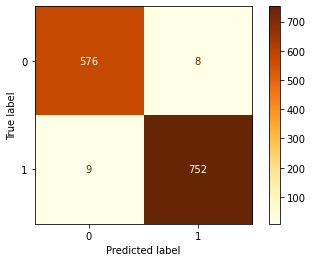

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       584
           1       0.99      0.99      0.99       761

    accuracy                           0.99      1345
   macro avg       0.99      0.99      0.99      1345
weighted avg       0.99      0.99      0.99      1345

Epoch 1/30
48/48 [==============================] - 7s 140ms/step - loss: 3.0357 - accuracy: 0.8884 - val_loss: 1.1162 - val_accuracy: 1.0000
Epoch 2/30
48/48 [==============================] - 7s 141ms/step - loss: 0.6272 - accuracy: 0.9862 - val_loss: 0.2467 - val_accuracy: 0.9950
Epoch 3/30
48/48 [==============================] - 7s 136ms/step - loss: 0.2112 - accuracy: 0.9813 - val_loss: 0.1120 - val_accuracy: 0.9950
Epoch 4/30
48/48 [==============================] - 7s 140ms/step - loss: 0.1321 - accuracy: 0.9860 - val_loss: 0.0748 - val_accuracy: 0.9950
Epoch 5/30
48/48 [==============================] - 7s 141ms/step - loss: 0.1056 - accuracy: 0.9867 - val

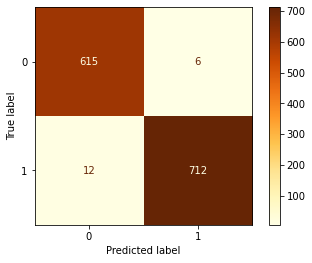

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       621
           1       0.99      0.98      0.99       724

    accuracy                           0.99      1345
   macro avg       0.99      0.99      0.99      1345
weighted avg       0.99      0.99      0.99      1345

Epoch 1/30
48/48 [==============================] - 7s 135ms/step - loss: 2.8533 - accuracy: 0.8964 - val_loss: 0.9278 - val_accuracy: 1.0000
Epoch 2/30
48/48 [==============================] - 6s 134ms/step - loss: 0.5543 - accuracy: 0.9757 - val_loss: 0.2549 - val_accuracy: 0.9950
Epoch 3/30
48/48 [==============================] - 7s 139ms/step - loss: 0.2245 - accuracy: 0.9864 - val_loss: 0.1920 - val_accuracy: 0.9950
Epoch 4/30
48/48 [==============================] - 6s 135ms/step - loss: 0.1443 - accuracy: 0.9846 - val_loss: 0.0864 - val_accuracy: 0.9950
Epoch 5/30
48/48 [==============================] - 7s 137ms/step - loss: 0.1150 - accuracy: 0.9864 - val

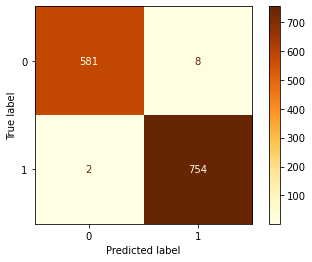

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       589
           1       0.99      1.00      0.99       756

    accuracy                           0.99      1345
   macro avg       0.99      0.99      0.99      1345
weighted avg       0.99      0.99      0.99      1345

Epoch 1/30
48/48 [==============================] - 6s 132ms/step - loss: 3.0071 - accuracy: 0.8873 - val_loss: 1.1020 - val_accuracy: 1.0000
Epoch 2/30
48/48 [==============================] - 6s 133ms/step - loss: 0.6042 - accuracy: 0.9844 - val_loss: 0.3519 - val_accuracy: 0.9650
Epoch 3/30
48/48 [==============================] - 6s 129ms/step - loss: 0.2174 - accuracy: 0.9853 - val_loss: 0.1133 - val_accuracy: 1.0000
Epoch 4/30
48/48 [==============================] - 6s 129ms/step - loss: 0.1479 - accuracy: 0.9854 - val_loss: 0.1076 - val_accuracy: 0.9950
Epoch 5/30
48/48 [==============================] - 6s 131ms/step - loss: 0.1129 - accuracy: 0.9866 - val

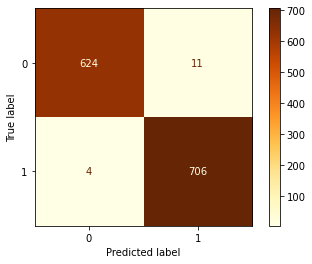

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       635
           1       0.98      0.99      0.99       710

    accuracy                           0.99      1345
   macro avg       0.99      0.99      0.99      1345
weighted avg       0.99      0.99      0.99      1345

Epoch 1/30
48/48 [==============================] - 7s 136ms/step - loss: 2.7873 - accuracy: 0.9156 - val_loss: 0.9121 - val_accuracy: 0.9650
Epoch 2/30
48/48 [==============================] - 6s 135ms/step - loss: 0.4495 - accuracy: 0.9846 - val_loss: 0.1781 - val_accuracy: 0.9950
Epoch 3/30
48/48 [==============================] - 6s 133ms/step - loss: 0.1955 - accuracy: 0.9755 - val_loss: 0.1067 - val_accuracy: 0.9950
Epoch 4/30
48/48 [==============================] - 6s 132ms/step - loss: 0.1411 - accuracy: 0.9866 - val_loss: 0.0947 - val_accuracy: 0.9950
Epoch 5/30
48/48 [==============================] - 7s 136ms/step - loss: 0.1121 - accuracy: 0.9878 - val

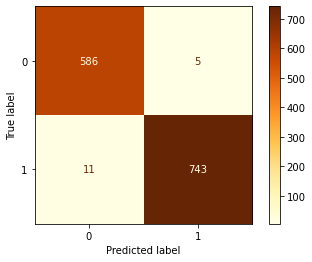

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       591
           1       0.99      0.99      0.99       754

    accuracy                           0.99      1345
   macro avg       0.99      0.99      0.99      1345
weighted avg       0.99      0.99      0.99      1345

Epoch 1/30
48/48 [==============================] - 7s 144ms/step - loss: 3.3820 - accuracy: 0.8838 - val_loss: 1.2751 - val_accuracy: 0.9950
Epoch 2/30
48/48 [==============================] - 7s 137ms/step - loss: 0.7748 - accuracy: 0.9759 - val_loss: 0.3622 - val_accuracy: 0.9950
Epoch 3/30
48/48 [==============================] - 7s 136ms/step - loss: 0.2718 - accuracy: 0.9856 - val_loss: 0.1396 - val_accuracy: 1.0000
Epoch 4/30
48/48 [==============================] - 6s 135ms/step - loss: 0.1549 - accuracy: 0.9865 - val_loss: 0.0917 - val_accuracy: 0.9950
Epoch 5/30
48/48 [==============================] - 6s 131ms/step - loss: 0.1199 - accuracy: 0.9874 - val

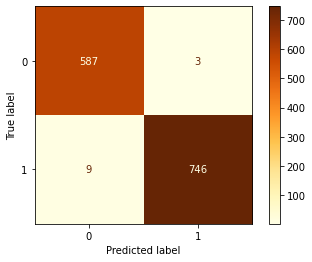

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       590
           1       1.00      0.99      0.99       755

    accuracy                           0.99      1345
   macro avg       0.99      0.99      0.99      1345
weighted avg       0.99      0.99      0.99      1345



In [8]:
y = data_final[94]
x = data_final.drop([94], axis=1)

x_np = np.asarray(x).astype(np.float32)
y_np = np.asarray(y).astype(np.float32)

kfold = KFold(n_splits=10, shuffle=True, random_state=32)

for train, test in kfold.split(x_np, y_np):
    x_train, x_test = x_np[train], x_np[test]
    y_train, y_test = y_np[train], y_np[test]
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    val_indices = 200
    x_val = x_train[-val_indices:]
    y_val = y_train[-val_indices:]
    
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    batch_size=256,
                    validation_data=(x_val, y_val)
                   )
    
    y_pred = model.predict(x_test)

    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    disp = disp.plot(cmap='YlOrBr')

    plt.show()
    print(classification_report(y_test, y_pred))